In [1]:
import infomap
import statistics
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
%load_ext autoreload
%autoreload 2

from analysis import *

In [3]:
networks = read_filenames(list_files())

match_ids(ground_truth_filename="multilayer_self_links", networks=networks)

outdir = "output/matched_ids"
remove_files(outdir)
write_networks(networks, outdir)

s = summarize(networks)

bipartite                  2172  4379 6 2.610
bipartite (non-bt)         3496  9609 5 2.607
clique (dir.)              1438  6761 5 3.137
clique (dir. self links)   1438  8198 4 2.782
multilayer                 2128 20893 5 3.530
multilayer (self links)    2190 28434 5 3.340


In [6]:
ami_score = ami(networks)

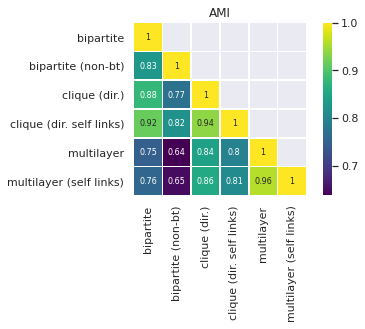

In [7]:
plot_heatmap(ami_score, title="AMI");

Text(0.5, 1.0, 'multilayer')

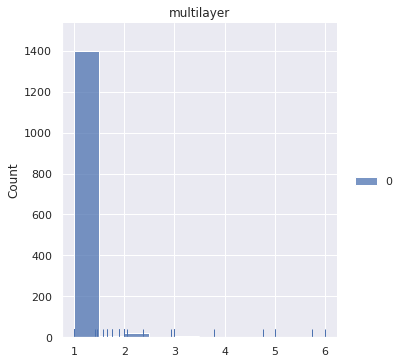

In [4]:
network = networks[4]
sns.displot(perplexity(network).values(), bins=10, rug=True)
plt.title(network.pretty_filename)

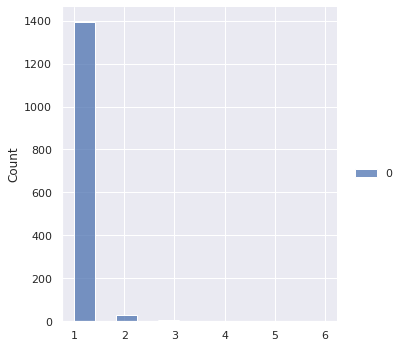

In [5]:
sns.displot(module_assignments(network).values())